In [1]:
%%time
import datetime

print('Starting at', datetime.datetime.now())

Starting at 2020-11-24 08:02:26.122323
CPU times: user 0 ns, sys: 1.72 ms, total: 1.72 ms
Wall time: 959 µs


In [2]:
import sys

!{sys.executable} -m pip install -r requirements.txt
!{sys.executable} -m pip install pyarrow

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
%%time
import boto3
import sagemaker

session = sagemaker.Session() 
region = session.boto_region_name 

bucket = 'sagemaker-jfox'
algo =  'linearlearner'
prefix = 'sagemaker/'+algo
role = sagemaker.get_execution_role()
print('Role', role)
print(f'Bucket {bucket} in region {region}')

Role arn:aws:iam::649592902942:role/service-role/AmazonSageMaker-ExecutionRole-20201021T144991
Bucket sagemaker-jfox in region eu-west-1
CPU times: user 746 ms, sys: 89.4 ms, total: 835 ms
Wall time: 2.87 s


In [4]:
%%time
import random
import pandas as pd
import pyarrow.parquet as pq
import os 

raw_data_filename = 'frauddetection.parquet.snappy'
 
s3 = boto3.resource('s3', region_name=region)

s3_path_snappy = 'prepareddataalltypes/datapreparation_20Nov2020_1605858525820/datapreparation_20Nov2020_1605858525820_part00000.parquet.snappy'

if not os.path.isfile(raw_data_filename):
   s3.Bucket(bucket).download_file(s3_path_snappy,  raw_data_filename)
 

CPU times: user 98.4 ms, sys: 3.4 ms, total: 102 ms
Wall time: 1.11 s


In [5]:
%%time 
table = pq.read_table(raw_data_filename)
df = table.to_pandas()
 
pd.set_option('display.max_rows', 10) 
 
print(len(df), 'data items')

6362620 data items
CPU times: user 1.16 s, sys: 843 ms, total: 2 s
Wall time: 671 ms


In [6]:
target_col = 'Fraudulent'

In [7]:

df = df.rename(columns = {'isFraud': target_col,
                          'type_CASH_OUT': 'type_CashOut',
                          'type_TRANSFER': 'type_Transfer',
                          'type_CASH_IN': 'type_CashIn',
                          'type_PAYMENT': 'type_Payment',
                          'oldbalanceOrg_nml': 'originOldBalance',
                          'oldBalanceOrigSign': 'originOldBalanceSign', 
                          'newbalanceOrig_nml': 'originNewBalance',
                          'negDeltaOrigin_nml': 'negativeDeltaInOrigin', 
                          'oldbalanceDest_nml': 'destinationOldBalance',
                          'newbalanceDest_nml': 'destinationNewBalance',
                          'expectedNewBalDest_nml': 'destinationExpectedNewBalance', # based on old value and delta   
                          'amount_nml': 'amount',
                          'hourOf24_radians': 'hourOf24_radians',# To be deleted after calculation
                          'isFlaggedFraud':'FlaggedFraud'#To be deleted
                         })


`type_X` columns where X in  `PAYMENT` `TRANSFER` `CASH_OUT` `DEBIT` `CASH_IN`
There was also `DEBIT`, but onehotting drops one of the types because of correlation.
All `isFraud` rows have `type` `TRANSFER` or `CASH_OUT`, never  `CASH_IN` or `PAYMENT` or `DEBIT`

Counts of each class to determine imbalance.

In [8]:
def count_positive_and_negative(df):
    num_positive = len(df.loc[  df[target_col] == 1 ])
    num_negative = len(df) - num_positive
    return num_positive, num_negative

num_positive, num_negative = count_positive_and_negative(df)

print('Fraud', num_positive, '; Not fraud', num_negative, '; Total', len(df))

Fraud 8213 ; Not fraud 6354407 ; Total 6362620


Plot distribution of positive vs negative, in log scale because of the imbalance

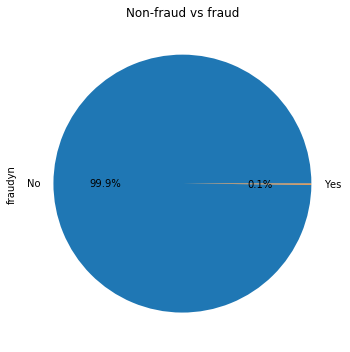

In [9]:
import math
import numpy as np
import matplotlib.pyplot as plt   

def plot_positive_negative_counts(df, target_col):
        df['fraudyn']=np.where(df[target_col]==1, 'Yes', 'No')
        df['fraudyn'].value_counts().plot.pie(figsize=(5, 5), autopct='%.1f%%')
        plt.title('Non-fraud vs fraud')
        plt.tight_layout()
        del df['fraudyn']
    
plot_positive_negative_counts(df,target_col)

Check that target is on the left, per Sagemaker standard

In [10]:
assert target_col == df.columns.tolist()[0]

Transform hour of day to a form suited for cyclical data.

In [11]:
import numpy as np
hours_col = 'hourOf24_radians'
df['sineHourInDay'] = np.sin(df[hours_col])
df['cosineHourInDay'] = np.cos(df[hours_col])
df = df.drop(hours_col, axis=1)
df

,Fraudulent,type_CashIn,type_CashOut,type_Payment,type_Transfer,amount,originOldBalance,originOldBalanceSign,originNewBalance,negativeDeltaInOrigin,destinationOldBalance,destinationExpectedNewBalance,destinationNewBalance,sineHourInDay,cosineHourInDay
0,0,0,0,1,0,-0.281560,-0.229810,1,-0.237622,0.211876,-0.323814,-0.350732,-0.333411,0.258626,0.965977
1,0,0,0,1,0,-0.294767,-0.281359,1,-0.285812,0.157490,-0.323814,-0.352933,-0.333411,0.258626,0.965977
2,1,0,0,0,1,-0.297555,-0.288654,1,-0.292442,0.146011,-0.323814,-0.353398,-0.333411,0.258626,0.965977
3,1,0,1,0,0,-0.297555,-0.288654,1,-0.292442,0.146011,-0.317582,-0.347552,-0.333411,0.258626,0.965977
4,0,0,0,1,0,-0.278532,-0.274329,1,-0.282221,0.224345,-0.323814,-0.350227,-0.333411,0.258626,0.965977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,1,0,1,0,0,0.264665,-0.171108,1,-0.292442,2.461161,-0.323814,-0.259692,-0.240959,-0.263246,0.964729
6362616,1,0,0,0,1,10.153952,1.896491,1,-0.292442,43.183974,-0.323814,1.388562,-0.333411,-0.263246,0.964729
6362617,1,0,1,0,0,10.153952,1.896491,1,-0.292442,43.183974,-0.303665,1.407466,1.403027,-0.263246,0.964729
6362618,1,0,0,0,1,1.109765,0.005581,1,-0.292442,5.941173,-0.323814,-0.118839,-0.333411,-0.263246,0.964729


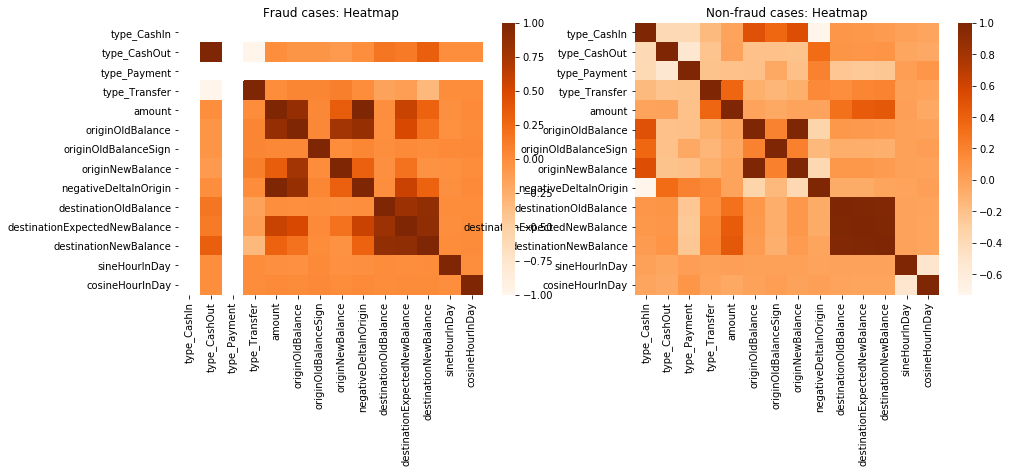

In [12]:
import seaborn  

fig, axes = plt.subplots( 1,2, figsize=(15,5))

def heatmap(fraud_cases):
    lbl='Fraud' if  fraud_cases else 'Non-fraud'
    # Coerced to int, below
    axes[1-fraud_cases].set_title(f'{lbl} cases: Heatmap')
    seaborn.heatmap(df.query(f'{target_col} == {fraud_cases}').drop([target_col], 1).corr(),  cmap='Oranges', ax=axes[1-fraud_cases])

heatmap(True)
heatmap(False)

plt.show()

# Split  with randomization

In [13]:
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import time
import json
import sagemaker.amazon.common as smac
import os

In [14]:
rand_split = np.random.rand(len(df))
train_cutoff = 0.05
validation_cutoff = 0.10
train_list = rand_split < train_cutoff
val_list = (rand_split >= train_cutoff) & (rand_split < validation_cutoff)
test_list = rand_split >= validation_cutoff

data_train = df[train_list]
data_val = df[val_list]
data_test = df[test_list]
print('Data: Training', len(data_train), '; Validation:', len(data_val), ';Testing: ', len(test_list))

train_y = ( data_train.iloc[:,1]  ).to_numpy();
train_X = data_train.iloc[:,2:].to_numpy();

val_y = ( data_val.iloc[:,1]  ).to_numpy();
val_X = data_val.iloc[:,2:].to_numpy();

test_y =  (data_test.iloc[:,1]  ).to_numpy();
test_X = data_test.iloc[:,2:].to_numpy();

data_train.head(10)

Data: Training 318074 ; Validation: 317794 ;Testing:  6362620


,Fraudulent,type_CashIn,type_CashOut,type_Payment,type_Transfer,amount,originOldBalance,originOldBalanceSign,originNewBalance,negativeDeltaInOrigin,destinationOldBalance,destinationExpectedNewBalance,destinationNewBalance,sineHourInDay,cosineHourInDay
15,0,0,1,0,0,0.081595,-0.283410,1,-0.292442,0.249282,-0.322319,-0.288802,-0.319391,0.258626,0.965977
61,0,0,0,0,0,-0.290386,-0.285165,1,-0.290477,0.175533,-0.320667,-0.349251,-0.333411,0.258626,0.965977
78,0,0,0,0,1,-0.227122,-0.285128,1,-0.292442,0.215448,-0.306780,-0.325677,-0.326867,0.258626,0.965977
82,0,0,0,0,1,0.074098,-0.288716,0,-0.292442,0.144777,-0.219471,-0.193559,-0.333411,0.258626,0.965977
86,0,0,0,0,1,0.619624,-0.288716,0,-0.292442,0.144777,-0.153395,-0.040643,-0.333411,0.258626,0.965977
161,0,0,1,0,0,0.181804,-0.288716,0,-0.292442,0.144777,-0.067445,-0.032976,0.051029,0.258626,0.965977
195,0,0,1,0,0,0.050522,-0.288716,0,-0.292442,0.144777,0.100494,0.102704,-0.327372,0.258626,0.965977
203,0,0,1,0,0,-0.148876,-0.288716,0,-0.292442,0.144777,-0.277623,-0.285281,-0.333411,0.258626,0.965977
216,0,0,1,0,0,-0.191059,-0.288716,0,-0.292442,0.144777,-0.206602,-0.225679,-0.328785,0.258626,0.965977
221,0,0,0,1,0,-0.285091,-0.254153,1,-0.260938,0.197336,-0.323814,-0.351321,-0.333411,0.258626,0.965977


In [15]:
train_file = 'linear_train.data.csv'

f = io.BytesIO()
smac.write_numpy_to_dense_tensor(f, train_X.astype('float32'), train_y.astype('float32'))
f.seek(0)
 
 

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', train_file)).upload_fileobj(f)
 

In [26]:
validation_file = 'linear_validation.data.csv'
f = io.BytesIO()
smac.write_numpy_to_dense_tensor(f, val_X.astype('float32'), val_y.astype('float32'))
f.seek(0)
 
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation', validation_file)).upload_fileobj(f)
 

In [27]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'linear-learner')

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


In [28]:

linear_training_params = {
    "RoleArn": role,
    "TrainingJobName": None, #Must fill in  
    "AlgorithmSpecification": {
        "TrainingImage": container,
        "TrainingInputMode": "File"
    },
    "ResourceConfig": {
        "InstanceCount": 4,
        "InstanceType": "ml.c4.2xlarge",
        "VolumeSizeInGB": 10
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/train/".format(bucket, prefix),
                    "S3DataDistributionType": "ShardedByS3Key"
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/validation/".format(bucket, prefix),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None"
        }

    ],
    "OutputDataConfig": {
        "S3OutputPath": "s3://{}/{}/".format(bucket, prefix)
    },
    "HyperParameters": {
        "feature_dim": "-999999",# replace
        "mini_batch_size": "4",
        'binary_classifier_model_selection_criteria': 'f1',
        "predictor_type": "binary_classifier",
       # "epochs": "10",
        "num_models": "32",
        "loss": "absolute_loss"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 60 * 60
    }
}


In [29]:
%%time
linear_job = 'DEMO-linear-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
print("Job name is:", linear_job)

linear_training_params['TrainingJobName'] = linear_job
feature_dim=len(df.columns)-2 #Why is -2 needed to match the error-message's determination of feature dim?
print('feature_dim', feature_dim)
linear_training_params['HyperParameters']['feature_dim'] = str(feature_dim)

region = boto3.Session().region_name
sm = boto3.client('sagemaker')

sm.create_training_job(**linear_training_params)
counter = 0
status = 'InProgress'
while status == 'InProgress':
    status = sm.describe_training_job(TrainingJobName=linear_job)['TrainingJobStatus']
    print(status,counter,'min',end='; ')
    time.sleep(30)
    counter += 0.5

err_message = sm.describe_training_job(TrainingJobName=linear_job).get('FailureReason')
if err_message:
    print('Failure reason if any: {}'.format(err_message))
    
print('Done:', status)

Job name is: DEMO-linear-2020-11-24-08-09-36
feature_dim 13
InProgress 0 min; InProgress 0.5 min; InProgress 1.0 min; InProgress 1.5 min; InProgress 2.0 min; InProgress 2.5 min; InProgress 3.0 min; InProgress 3.5 min; InProgress 4.0 min; InProgress 4.5 min; InProgress 5.0 min; InProgress 5.5 min; InProgress 6.0 min; InProgress 6.5 min; InProgress 7.0 min; InProgress 7.5 min; InProgress 8.0 min; InProgress 8.5 min; InProgress 9.0 min; InProgress 9.5 min; InProgress 10.0 min; InProgress 10.5 min; InProgress 11.0 min; InProgress 11.5 min; InProgress 12.0 min; InProgress 12.5 min; InProgress 13.0 min; InProgress 13.5 min; InProgress 14.0 min; InProgress 14.5 min; InProgress 15.0 min; InProgress 15.5 min; InProgress 16.0 min; InProgress 16.5 min; InProgress 17.0 min; InProgress 17.5 min; InProgress 18.0 min; InProgress 18.5 min; InProgress 19.0 min; InProgress 19.5 min; InProgress 20.0 min; InProgress 20.5 min; InProgress 21.0 min; InProgress 21.5 min; InProgress 22.0 min; InProgress 22.5 m

---
## Host

Deploy the trained model to an endpoint.

In [30]:
import datetime 
import time

endpoint_name = 'fraud-detect-endpoint'
training_job_name=linear_job
model_name = training_job_name + '-model'

info = session.describe_training_job(training_job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

primary_container = {
  'Image': container,
  'ModelDataUrl': model_data
}

create_model_response = session.create_model(
      name = model_name,
      role = role,
      container_defs = primary_container)


endpoint_config_name = session.create_endpoint_config(name=endpoint_name + '-config-' + datetime.datetime.now().strftime('%m%d-%H%M%S'),
                                              model_name=model_name,
                                              initial_instance_count=1,
                                              instance_type='ml.m5.xlarge',
                                              accelerator_type='ml.eia2.medium')

client = boto3.client('sagemaker')
counter = 0
try_now = True
while try_now:
  counter += 0.5
  try:
     updated_endpoint = client.update_endpoint(EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name)
     try_now = False
  except Exception as e:
     if 'Could not find endpoint'  in str(e):
        print('Could not find endpoint; Trying to create')
        updated_endpoint=client.create_endpoint(EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name)
        try_now = False
     elif 'Cannot update in-progress endpoint' in str(e):
        print(f'{counter} min: Cannot update in-progress endpoint; retrying', end='. ')
        time.sleep(30)
        try_now = True
     else:  
        raise e

endpt_status = 'Updating'
minutes_passed = 0 
while endpt_status in ['Updating', 'Creating']:
    minutes_passed += 0.5
    endpt_status = client.describe_endpoint(EndpointName=endpoint_name)['EndpointStatus']
    print(f'{minutes_passed} min: {endpt_status} endpoint; ',end='')
    time.sleep(30)

print('\nFinished creating or updating endpoint')

s3://sagemaker-jfox/sagemaker/linearlearner/DEMO-linear-2020-11-24-08-09-36/output/model.tar.gz
Could not find endpoint; Trying to create
0.5 min: Creating endpoint; 1.0 min: Creating endpoint; 1.5 min: Creating endpoint; 2.0 min: Creating endpoint; 2.5 min: Creating endpoint; 3.0 min: Creating endpoint; 3.5 min: Creating endpoint; 4.0 min: Creating endpoint; 4.5 min: Creating endpoint; 5.0 min: Creating endpoint; 5.5 min: Creating endpoint; 6.0 min: Creating endpoint; 6.5 min: Creating endpoint; 7.0 min: InService endpoint; 
Finished creating or updating endpoint


---

## Evaluation

Now that we have our hosted endpoint, we can generate predictions from  the  test data set.

Compared actual to predicted values of whether the transaction was a "fraud" (`1`) or not (`0`).  Then we'll produce a  confusion matrix.

In [77]:
%%time

def np2csv(arr):
    csv = io.BytesIO()
    np.savetxt(csv, arr, delimiter=',', fmt='%g')
    ret=csv.getvalue().decode().rstrip()
    return ret

 
runtime= boto3.client('runtime.sagemaker')
#payload = np2csv(test_X)
sample_len=100_000


def display(data):
    print('Count', len(data), 
        '; Positives', sum(1 for y in data if y),
      '; Negatives', sum(1 for y in data if not y))

print('Test data: ', end="")
display(test_y[:sample_len])
    
def batch_predict(data, batch_size):

    def do_predict(data_):
       payload = np2csv(data_)

       response = runtime.invoke_endpoint(EndpointName=endpoint_name,
                                   ContentType='text/csv',
                                   Body=payload)
       result = json.loads(response['Body'].read().decode())

       test_pred = np.array([r['predicted_label'] for r in result['predictions']])
       test_pred = [float(num) for num in test_pred]
       assert all(t in [0.0, 1.0] for t in test_pred) , test_pred 
       test_pred_int = [round(num) for num in test_pred]
       return test_pred_int

    len_data = len(data)
    arrs = []
    
    for offset in range(0, len_data, batch_size):
        if offset+batch_size < len_data:
            results = do_predict(data[offset:(offset+batch_size)])
            arrs.extend(results)
        else:
            arrs.extend(do_predict(data[offset:len_data]))
        sys.stdout.write('.')
    return(arrs)

preds_ml = batch_predict(test_X[:sample_len], 1000)
print('\nPredictions: ', end='')
display(preds_ml)

In [81]:
labels_ml = test_y[:sample_len]

Test data: Count 100000 ; Positives 20229 ; Negatives 79771
....................................................................................................
Predictions: Count 100000 ; Positives 20326 ; Negatives 79674
CPU times: user 1.18 s, sys: 20.7 ms, total: 1.2 s
Wall time: 5.21 s


content_type is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [82]:
def metrics(labels_, predictions):
   assert len(labels_)==len(predictions)
   
   print(f'n = {len(labels_)}')
  
   actual_pos = sum(1 for i in range(len(labels_)) if 1 == labels_[i])
   actual_neg = sum(1 for i in range(len(labels_)) if 0 == labels_[i])

   pred_pos = sum(1 for i in range(len(predictions)) if 1 == predictions[i])
   pred_neg = sum(1 for i in range(len(predictions)) if 0 == predictions[i])

   true_pos = sum(1 for i in range(len(predictions)) if predictions[i] == 1 == labels_[i])
   true_neg = sum(1 for i in range(len(predictions)) if predictions[i] == 0 == labels_[i])

   false_pos=sum(1 for i in range(len(predictions)) if predictions[i] == 1 and 0 == labels_[i])
   false_neg=sum(1 for i in range(len(predictions)) if predictions[i] == 0 and 1 == labels_[i])
   
   print('true_pos', true_pos, 'false_pos', false_pos)
   print('true_neg', true_neg, 'false_neg', false_neg)

   assert  true_pos+false_pos == pred_pos
  
   recall = true_pos / (true_pos + false_neg)
   print(f'Recall = {recall:.2f}')
   precision = true_pos / (true_pos + false_pos)

   print(f'Precision = {precision:.2f}')
   if precision+recall == 0:
       f1=float('inf')
   else:
       f1 = (2 * precision * recall) / (precision + recall)
       
   print(f'F1 = {f1:.2f}')
   error = sum(1 for i in range(len(predictions)) if predictions[i] != labels_[i]) / float(len(predictions))
   print(f'Error rate = {error:.2f}')

   assert recall <= f1 <= precision or precision <= f1 <= recall  or precision==recall==0
   assert true_pos + false_neg == actual_pos
   assert true_neg + false_pos == actual_neg
   assert len(predictions)==len(labels_)
   assert actual_pos + actual_neg==len(labels_)
   assert true_neg + false_neg== pred_neg
   assert pred_pos + pred_neg==len(predictions)

print('ML-based metrics')
metrics(labels_ml, preds_ml)
#print('Full  metrics') 
#metrics(labels_all, preds_all)

ML-based metrics
n = 100000
true_pos 20153 false_pos 173
true_neg 79598 false_neg 76
Recall = 1.00
Precision = 0.99
F1 = 0.99
Error rate = 0.00


Show confusion matrix.

In [83]:
pd.crosstab(index=np.array(labels_ml), columns=np.array(preds_all), rownames=['actual fraud'],  colnames=['predicted as fraud'])

NameError: name 'labels_all' is not defined

Clean up to save money

In [ ]:
#session.delete_endpoint(xgb_predictor.endpoint)